# Neural Machine Translation

By *Sai Charitha Gonavaram , Manusree Gurijala, Akshitha Atmuri*

In this project, Transformers with attention mechanism is implemented. Along with this, Sequence to Sequence  (LSTM) model and LSTM with attention are implemented and their performances are compared to propose the efficient model.

In [31]:
import torch
from torchtext.data.metrics import bleu_score
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter 
import spacy
import time
import sys

In [25]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [26]:
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


# Loading and pre-processing the data

In [27]:
source_german = spacy.load("de")
spacy_eng = spacy.load("en")

In [28]:
def tokenize_ger(text):
    return [tok.text for tok in source_german.tokenizer(text)]


def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]


In [ ]:
german = Field(tokenize=tokenize_ger, lower=True, init_token="<sos>", eos_token="<eos>")

english = Field(
    tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>"
)

train_data, valid_data, test_data = Multi30k.splits(
    exts=(".de", ".en"), fields=(german, english)
)

german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

# Implemeting Key methods

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = sentence_translation(model, src, german, english, device)
        prediction = prediction[:-1]  

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)


In [ ]:
def sentence_translation(model, sentence, german, english, device, max_length=50):
    source_german = spacy.load("de")

    if type(sentence) == str:
        tokens = [token.text.lower() for token in source_german(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)
    text_to_indices = [german.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)
    
    #torch. no_grad() basically skips the gradient calculation over the weights. That means you are not changing any weight in the specified layers
    with torch.no_grad():
        hidden, cell = model.encoder(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]



In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


# Implementing Seq2Seq LSTM model

Model consists of encoder and decoder. A Seq2Seq class was implemented which combines both encoder and decoder. The encoder and decoder may be any form of architecture, with RNN-type networks such as LSTM or GRU. We have implemented LSTM for both encoder and decoder. 

For encoder, input parameters are input size, embedding size, hidden size, number of layers and number of nodes to drop. Embedding was performed on the inputs and then LSTM was run. At each time-step, the encoder receives both the current word. x(i), and the hidden state from the previous time-step, h(i)-1, and outputs a new hidden state, h(i). 


After passing the final word x(i), into the encoder, we use the final hidden state h(i), as the context vector, i.e., h(i)=z. The entire source sentence is represented as a vector. 


The decoder is an LSTM, whose initial states are set to the final states of the Encoder LSTM, i.e., the context vector from the encoder’s final cell is fed into the decoder’s network’s first cell. The decoder receives the current word y(i) at t, as well as the hidden state from the previous time step, s(i)-1, where the original decoder hidden state, s0, is the final encoder hidden state. 


In [ ]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, emb_size, num_of_features_hidden, output_size, num_of_layers, drop_ot):
        super(Decoder, self).__init__()
        
        self.num_of_features_hidden = num_of_features_hidden
        self.num_of_layers = num_of_layers
        self.dropout = nn.Dropout(drop_ot)
        #Embedding the inputs
        self.embdng = nn.Embedding(input_size, emb_size)
        #Hidden size of the encoder and decoder are same
        self.rnn = nn.LSTM(emb_size, num_of_features_hidden, num_of_layers, dropout=drop_ot)
        #Fully connected layers
        self.fc = nn.Linear(num_of_features_hidden, output_size)

    def forward(self, y, hidden, cell):
        #Decoder predicts one word at a time and given the previous predicted value and the output it predicts the current word
        x = y.unsqueeze(0)
        #Calling the embedding
        embdng = self.dropout(self.embdng(x))
        #Running RNN 
        #For decoder, outputs hidden and cell, all of them are used unlike encoder
        outputs, (hidden, cell) = self.rnn(embdng, (hidden, cell))
        predictions = self.fc(outputs)
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size, num_of_features_hidden, num_of_layers, drop_ot):
        super(Encoder, self).__init__()
       
       
        self.num_of_features_hidden = num_of_features_hidden
        self.num_of_layers = num_of_layers
        #Defining how many nodes to drop

        self.dropout = nn.Dropout(drop_ot)
        #Running embedding on the inputs

        self.embdng = nn.Embedding(input_size, emb_size)
        #Running RNN on the embedded inputs
        self.rnn = nn.LSTM(emb_size, num_of_features_hidden, num_of_layers, dropout=drop_ot)

    def forward(self, long_vector):
        #Getting embedding
        embdng = self.dropout(self.embdng(long_vector))
        #Calling RNN on the embedding
        outputs, (hidden, cell) = self.rnn(embdng)
        return hidden, cell

In [ ]:
#Calling both encoder and decoder together
class Sequence2Sequence(nn.Module):
    def __init__(self, encoder, decoder):
        super(Sequence2Sequence, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    #target is the correct translation
    #t_f_ratio is teacher force ratio

    def forward(self, source, target, t_f_ratio=0.5):
        trgt_length = target.shape[0]
        batch_size = source.shape[1]
        target_vocab_size = len(english.vocab)

        outputs = torch.zeros(trgt_length, batch_size, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)
        #Stating token
        y = target[0]

        for t in range(1, trgt_length):
            #Calling the decoder
            output, hidden, cell = self.decoder(y, hidden, cell)
            
            outputs[t] = output
            #We will get the best gusess
            
            best_guess = output.argmax(1)
.           #Teacher forcing is a strategy for training recurrent neural networks that uses
            # ground truth as input, instead of model output from a prior time step as an input.
            y = target[t] if random.random() < t_f_ratio else best_guess

        return outputs


In [ ]:
num_epochs = 50
l_r = 3e-4
batch_size = 64


load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size_decoder = len(english.vocab)
input_size_encoder = len(german.vocab)
output_size = len(english.vocab)
num_of_layers = 2
num_of_features_hidden = 1024  
dec_dropout = 0.5
enc_dropout = 0.5
decoder_emb_size = 300
encoder_emb_size = 300

step = 0
writer = SummaryWriter(f"runs/loss_plot")



In [ ]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

encoder_net = Encoder(
    input_size_encoder, encoder_emb_size, num_of_features_hidden, num_of_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_emb_size,
    num_of_features_hidden,
    output_size,
    num_of_layers,
    dec_dropout,
).to(device)

In [ ]:

sentence = "eine mutter und ihr kleiner sohn genießen einen schönen tag im freien."


In [ ]:
start = time.time()

model = Sequence2Sequence(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=l_r)


pad_idx = english.vocab.stoi["<pad>"]
#Loss function
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

#Load checkpoint
if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)


sentence = "eine mutter und ihr kleiner sohn genießen einen schönen tag im freien."

for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    #Save Checkpoint
    save_checkpoint(checkpoint)

    model.eval()

    translated_sentence = sentence_translation(
        model, sentence, german, english, device, max_length=50
    )

    print(f"Translated example sentence: \n {translated_sentence}")

    model.train()

    for batch_idx, batch in enumerate(train_iterator):
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)

        output = model(inp_data, target)

        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
         
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
        writer.add_scalar("Training loss", loss, global_step=step)
        step += 1


score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score*100:.2f}")

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 570kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 173kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 160kB/s]


[Epoch 0 / 50]
=> Saving checkpoint
Translated example sentence: 
 ['pressure', 'ally', 'ally', 'ally', 'bunches', 'threw', 'nintendo', 'shacking', 'studio', 'straight', 'straight', 'tilts', 'very', 'overcoat', 'overcoat', 'labor', 'striped', 'striped', 'striped', 'striped', 'threw', 'buckets', 'buckets', 'actors', 'him', 'carts', 'carts', 'doing', 'surfers', 'surfers', 'topless', 'forces', 'forces', 'tanned', 'casting', 'casting', 'reception', 'reception', 'fan', 'cape', 'cape', 'cape', 'cape', 'cape', 'sodas', 'sodas', 'adults', 'adults', 'graduation', 'graduation']
[Epoch 1 / 50]
=> Saving checkpoint
Translated example sentence: 
 ['a', 'young', 'boy', 'is', 'a', 'a', 'a', 'a', 'a', 'a', 'a', '.', '<eos>']
[Epoch 2 / 50]
=> Saving checkpoint
Translated example sentence: 
 ['a', 'mother', 'and', 'a', 'and', 'a', 'are', 'are', 'a', 'a', 'a', '.', '<eos>']
[Epoch 3 / 50]
=> Saving checkpoint
Translated example sentence: 
 ['a', 'mother', 'and', 'a', 'and', 'a', 'a', 'a', 'a', 'in', 'th

# Implementing Seq2Seq LSTM with attention

Bidirectional RNN has hidden states flowing from the left and then towards right. Encoder on the top is trying to predict the target words y  for specific word at time t. The context vector here is the weighted sum of the hidden states. This will signify how much attention are we going to pay for each hidden state. This context vector is sent to the decoder. For attention, we compute energy from previous hidden state of the decoder and the current state of encoder. 

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, emb_size, num_of_features_hidden, output_size, num_of_layers, drop_ot):
        super(Decoder, self).__init__()
        self.num_of_features_hidden = num_of_features_hidden
        self.num_of_layers = num_of_layers
        #Calling Embedding
        self.embdng = nn.Embedding(input_size, emb_size)

        #RNN now takes hidden_Size*2 + emb_size as its bidirectional
        self.rnn = nn.LSTM(num_of_features_hidden * 2 + emb_size, num_of_features_hidden, num_of_layers)
        
        #We are taking hidden state from encoder and take previous one from decoder as well, thats why its times 3
        self.energy = nn.Linear(num_of_features_hidden * 3, 1)
        #Fully connected layer
        self.fc = nn.Linear(num_of_features_hidden, output_size)
        self.dropout = nn.Dropout(drop_ot)
        self.softmax = nn.Softmax(dim=0)
        #Activation fuction RELU is used
        self.relu = nn.ReLU()

    def forward(self, x, encoder_states, hidden_decoder, cell):
        x = x.unsqueeze(0)

        embdng = self.dropout(self.embdng(x))
        sequence_length = encoder_states.shape[0]

        #Reshaping hidden_states of decoder in order to concatenate with encoder hidden states
        hidden_reshaped = hidden_decoder.repeat(sequence_length, 1, 1)
        
        #For energy we gotta send hidden states from the encoder and decoder
        energy = self.relu(self.energy(torch.cat((hidden_reshaped, encoder_states), dim=2)))
        
        #normalising energy
        attention = self.softmax(energy)
        
        #Contect vectot is calculated
        #Element wise multiplication of attention with encoder states
        contxt_vctr = torch.einsum("snk,snl->knl", attention, encoder_states)
        
        #This is RNN Input
        rnn_input = torch.cat((contxt_vctr, embdng), dim=2)
        
        #Sending rnn_input to RNN
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        #Doing predictions
        predictions = self.fc(outputs).squeeze(0)
        
        #returning predictions, hidden and cell states

        return predictions, hidden, cell


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size, num_of_features_hidden, num_of_layers, drop_ot):
        super(Encoder, self).__init__()
        self.num_of_features_hidden = num_of_features_hidden
        self.num_of_layers = num_of_layers
        #Calling Embedding inpus
        self.embdng = nn.Embedding(input_size, emb_size)
        #Running LSTM on embedded input
        #Choosing bidirectional as True as we are implementing birectional RNN
        self.rnn = nn.LSTM(emb_size, num_of_features_hidden, num_of_layers, bidirectional=True)
        
        #Implementing fully connected layers
        self.fc_hidden = nn.Linear(num_of_features_hidden * 2, num_of_features_hidden)
        self.fc_cell = nn.Linear(num_of_features_hidden * 2, num_of_features_hidden)
        self.dropout = nn.Dropout(drop_ot)

    def forward(self, x):
        embdng = self.dropout(self.embdng(x))
        #Calling RNN
        encoder_states, (hidden, cell) = self.rnn(embdng)
       
        #Adding the first hidden for the forward one and next one for the backward one
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        #implementing same as hidden for cell state 
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))
        
        #We are returing encoder_states as we need hidden states at each time step
        return encoder_states, hidden, cell



In [ ]:
#Calling both encoder and decoder together
class Sequence2Sequence(nn.Module):
    def __init__(self, encoder, decoder):
        super(Sequence2Sequence, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    #target is the correct translation
    #t_f_ratio is teacher force ratio

    def forward(self, source, target, t_f_ratio=0.5):
        trgt_length = target.shape[0]
        batch_size = source.shape[1]
        target_vocab_size = len(english.vocab)

        outputs = torch.zeros(trgt_length, batch_size, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)
        #Stating token
        y = target[0]

        for t in range(1, trgt_length):
            #Calling the decoder
            output, hidden, cell = self.decoder(y, hidden, cell)
            
            outputs[t] = output
            #We will get the best gusess
            
            best_guess = output.argmax(1)
.           #Teacher forcing is a strategy for training recurrent neural networks that uses
            # ground truth as input, instead of model output from a prior time step as an input.
            y = target[t] if random.random() < t_f_ratio else best_guess

        return outputs


In [ ]:
num_epochs = 50
l_r = 3e-4
batch_size = 64


load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size_decoder = len(english.vocab)
input_size_encoder = len(german.vocab)
output_size = len(english.vocab)
num_of_layers = 2
num_of_features_hidden = 1024  
dec_dropout = 0.5
enc_dropout = 0.5
decoder_emb_size = 300
encoder_emb_size = 300

step = 0
writer = SummaryWriter(f"runs/loss_plot")



In [ ]:

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

encoder_net = Encoder(
    input_size_encoder, encoder_emb_size, num_of_features_hidden, num_of_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_emb_size,
    num_of_features_hidden,
    output_size,
    num_of_layers,
    dec_dropout,
).to(device)


In [ ]:
start = time.time()
model = Sequence2Sequence(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=l_r)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)


sentence = "eine mutter und ihr kleiner sohn genießen einen schönen tag im freien."


for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

    model.eval()

    translated_sentence = sentence_translation(
        model, sentence, german, english, device, max_length=50
    )

    print(f"Translated example sentence: \n {translated_sentence}")

    model.train()

    for batch_idx, batch in enumerate(train_iterator):
    
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)

        output = model(inp_data, target)

        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        writer.add_scalar("Training loss", loss, global_step=step)
        step += 1

score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score * 100:.2f}")

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 969kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 274kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 268kB/s]


[Epoch 0 / 50]
=> Saving checkpoint
Translated example sentence: 
 ['learning', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning', 'learning', 'bulls', 'vacuum', 'learning']
[Epoch 1 / 50]
=> Saving checkpoint
Translated example sentence: 
 ['a', 'and', 'and', 'and', 'and', 'a', 'are', 'at', 'a', 'at', 'a', '.', '.', '<eos>']
[Epoch 2 / 50]
=> Saving checkpoint
Translated example sentence: 
 ['a', 'mother', 'and', 'her', 'daughter', 'are', 'a', 'a', 'at', 'the', '.', '.', '<eos>']
[Epoch 3 / 50]
=> Saving checkpoint
Translated example sentence: 
 ['a', 'mother

# Implementing Transformers with Attention mechanism

Transformer block has the attention mechanism and the feed forward network. For each word, we create a Query vector, a Key vector, and a Value vector. These vectors are created by multiplying the embedding by three matrices that we trained during the training process. 

The encoder’s inputs first flow through a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word. The outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position. The decoder has both those layers, but between them is an attention layer that helps the decoder focus on relevant parts of the input sentence.


The output of the top encoder is then transformed into a set of attention vectors K and V. These are passed to each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence.


In [ ]:
#Attention layer
class Multi_Head_Attention_Layer(nn.Module):
    def __init__(self, hidn_dimn, n_heads, dropout, device):
        super().__init__()
        #hidn_dimn should be divded by n_heads
        assert hidn_dimn % n_heads == 0
        
        self.hidn_dimn = hidn_dimn
        self.n_heads = n_heads
        self.head_dim = hidn_dimn // n_heads
        #Passing on to linear layers
        self.fc_query = nn.Linear(hidn_dimn, hidn_dimn)
        self.fc_key = nn.Linear(hidn_dimn, hidn_dimn)
        self.fc_value = nn.Linear(hidn_dimn, hidn_dimn)
        
        self.fc_o = nn.Linear(hidn_dimn, hidn_dimn)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
              
        Querys = self.fc_query(query)
        Keys = self.fc_key(key)
        Values = self.fc_value(value)

        # view method returns a new tensor with the same data as the original tensor but of a different shape
        Q = Querys.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = Keys.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = Values.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Performs a matrix multiplication of the matrices         
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        #Normalising the energy value
        attention = torch.softmax(energy, dim = -1)
                
        x = torch.matmul(self.dropout(attention), V)
    
        
        x = x.permute(0, 2, 1, 3).contiguous()

        x = x.view(batch_size, -1, self.hidn_dimn)
        x = self.fc_o(x)
        return x, attention

In [ ]:
#Feed Forward Layer
class Positionwise_FeedforwardLayer(nn.Module):
    def __init__(self, hidn_dimn, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hidn_dimn, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidn_dimn)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #Skip connection
        x = self.dropout(torch.relu(self.fc_1(x)))
        #passing on to linear layer
        x = self.fc_2(x)
        return x

In [ ]:
#Combines attention layer and the feed forward layers
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hidn_dimn, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
    
        self.self_attn_layer_norm = nn.LayerNorm(hidn_dimn)
        self.ff_layer_norm = nn.LayerNorm(hidn_dimn)
        self.self_attention = Multi_Head_Attention_Layer(hidn_dimn, n_heads, dropout, device)
        self.positionwise_feedforward = Positionwise_FeedforwardLayer(hidn_dimn, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #Passing to attention layer
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        src = self.self_attn_layer_norm(src + self.dropout(_src))
         
        #Passing inputs to Feed Forward layer
        _src = self.positionwise_feedforward(src)
    
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        return src

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidn_dimn, 
                 num_of_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        #Input embdng
        self.tok_embdng = nn.Embedding(input_dim, hidn_dimn)
        #PositonWise embdng
        self.pos_embdng = nn.Embedding(max_length, hidn_dimn)
        
        #Calling Encoder layer here
        self.layers = nn.ModuleList([EncoderLayer(hidn_dimn, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(num_of_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hidn_dimn])).to(device)
        
    def forward(self, src, src_mask):
      
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        src = self.dropout((self.tok_embdng(src) * self.scale) + self.pos_embdng(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
        
            
        return src

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hidn_dimn, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hidn_dimn)
        self.enc_attn_layer_norm = nn.LayerNorm(hidn_dimn)
        self.ff_layer_norm = nn.LayerNorm(hidn_dimn)
        self.self_attention = Multi_Head_Attention_Layer(hidn_dimn, n_heads, dropout, device)
        self.encoder_attention = Multi_Head_Attention_Layer(hidn_dimn, n_heads, dropout, device)
        self.positionwise_feedforward = Positionwise_FeedforwardLayer(hidn_dimn, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
       #Self attention layer
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #Feed Forward layer
        _trg = self.positionwise_feedforward(trg)
        
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        return trg, attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hidn_dimn, 
                 num_of_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        #Output embdng
        self.tok_embdng = nn.Embedding(output_dim, hidn_dimn)
        #Poistion embdng
        self.pos_embdng = nn.Embedding(max_length, hidn_dimn)
        
        #Combining the decoder layers
        self.layers = nn.ModuleList([DecoderLayer(hidn_dimn, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(num_of_layers)])
        
        self.fc_out = nn.Linear(hidn_dimn, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hidn_dimn])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                        
        trg = self.dropout((self.tok_embdng(trg) * self.scale) + self.pos_embdng(pos))
                
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        
        output = self.fc_out(trg)
        
        return output, attention

In [ ]:
#Calling both encoder and decoder
class Sequence2Sequence(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        return src_mask
    
    def make_trg_mask(self, trg):
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
            
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

    def forward(self, src, trg):      
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask) 
        #Input to decoder is sent to masked multi head attention layer   
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
hidn_dimn = 256
DEC_HEADS = 8
ENC_HEADS = 8
Decoder_Layers = 3
Encoder_Layers = 3
DEC_DROPOUT = 0.1
ENC_DROPOUT = 0.1
DEC_dim_pf = 512
ENC_dim_pf = 512

enc = Encoder(INPUT_DIM, 
              hidn_dimn, 
              Encoder_Layers, 
              ENC_HEADS, 
              ENC_dim_pf, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              hidn_dimn, 
              Decoder_Layers, 
              DEC_HEADS, 
              DEC_dim_pf, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Sequence2Sequence(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
l_r = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = l_r)
#Defining loss function
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

start1 = time.time()
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

end1 = time.time()
hours, rem = divmod(end1-start1, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

/home/ben/miniconda3/envs/pytorch17/lib/python3.8/site-packages/torchtext-0.9.0a0+c38fd42-py3.8-linux-x86_64.egg/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 13s
	Train Loss: 4.222 | Train PPL:  68.172
	 Val. Loss: 3.021 |  Val. PPL:  20.516
Epoch: 02 | Time: 0m 13s
	Train Loss: 2.813 | Train PPL:  16.657
	 Val. Loss: 2.289 |  Val. PPL:   9.866
Epoch: 03 | Time: 0m 13s
	Train Loss: 2.236 | Train PPL:   9.358
	 Val. Loss: 1.981 |  Val. PPL:   7.252
Epoch: 04 | Time: 0m 13s
	Train Loss: 1.889 | Train PPL:   6.613
	 Val. Loss: 1.812 |  Val. PPL:   6.123
Epoch: 05 | Time: 0m 13s
	Train Loss: 1.644 | Train PPL:   5.177
	 Val. Loss: 1.712 |  Val. PPL:   5.538
Epoch: 06 | Time: 0m 14s
	Train Loss: 1.458 | Train PPL:   4.296
	 Val. Loss: 1.649 |  Val. PPL:   5.201
Epoch: 07 | Time: 0m 13s
	Train Loss: 1.311 | Train PPL:   3.710
	 Val. Loss: 1.624 |  Val. PPL:   5.072
Epoch: 08 | Time: 0m 13s
	Train Loss: 1.185 | Train PPL:   3.269
	 Val. Loss: 1.628 |  Val. PPL:   5.095
Epoch: 09 | Time: 0m 14s
	Train Loss: 1.074 | Train PPL:   2.928
	 Val. Loss: 1.613 |  Val. PPL:   5.016
Epoch: 10 | Time: 0m 14s
	Train Loss: 0.978 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.671 | Test PPL:   5.316 |


In [ ]:
def sentence_translation(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [ ]:
translation, attention = sentence_translation(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


<ipython-input-30-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-30-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


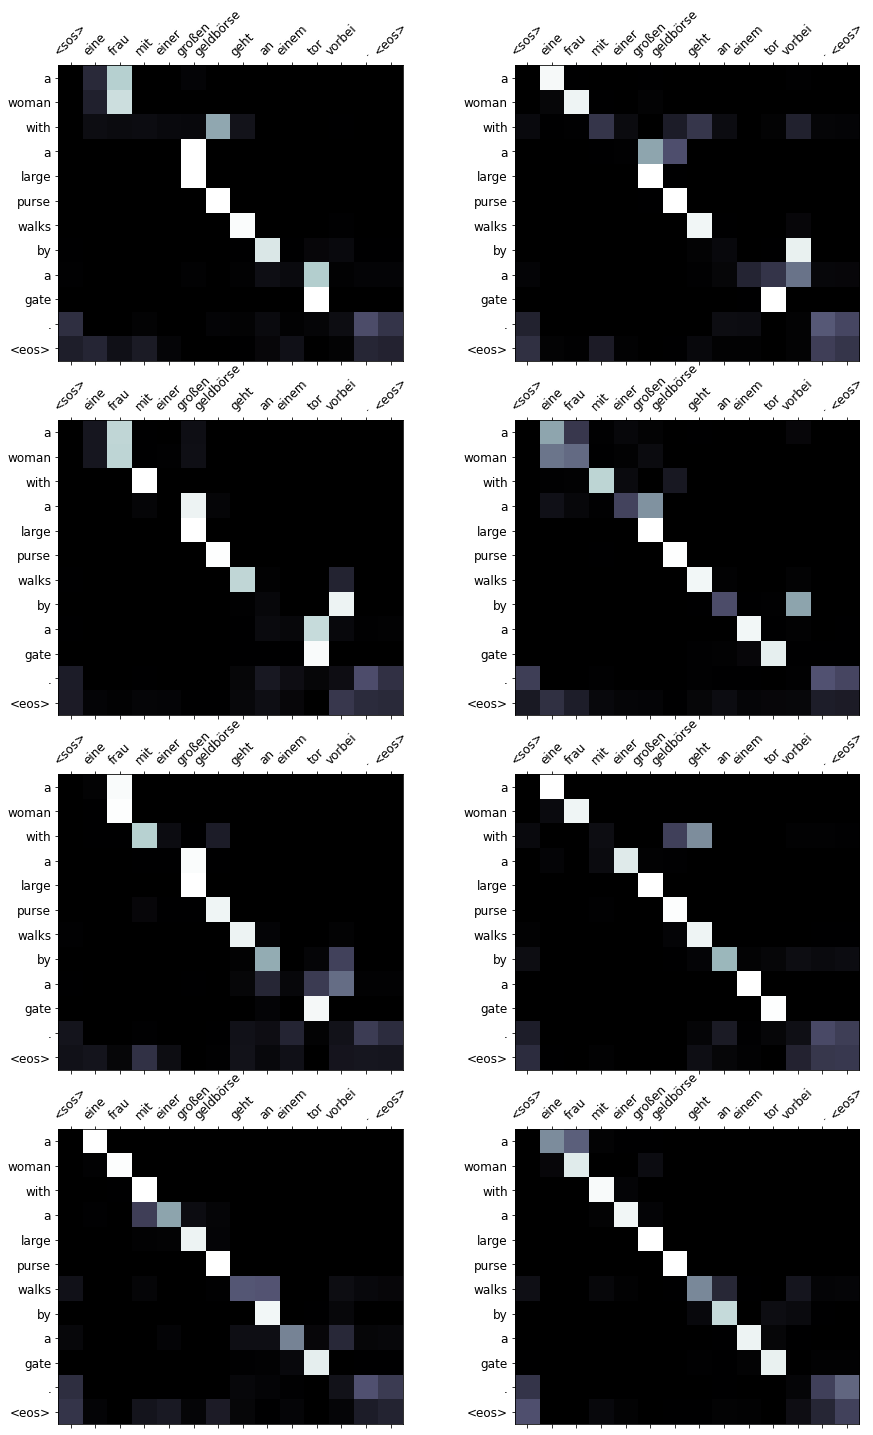

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [ ]:
translation, attention = sentence_translation(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


<ipython-input-30-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-30-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


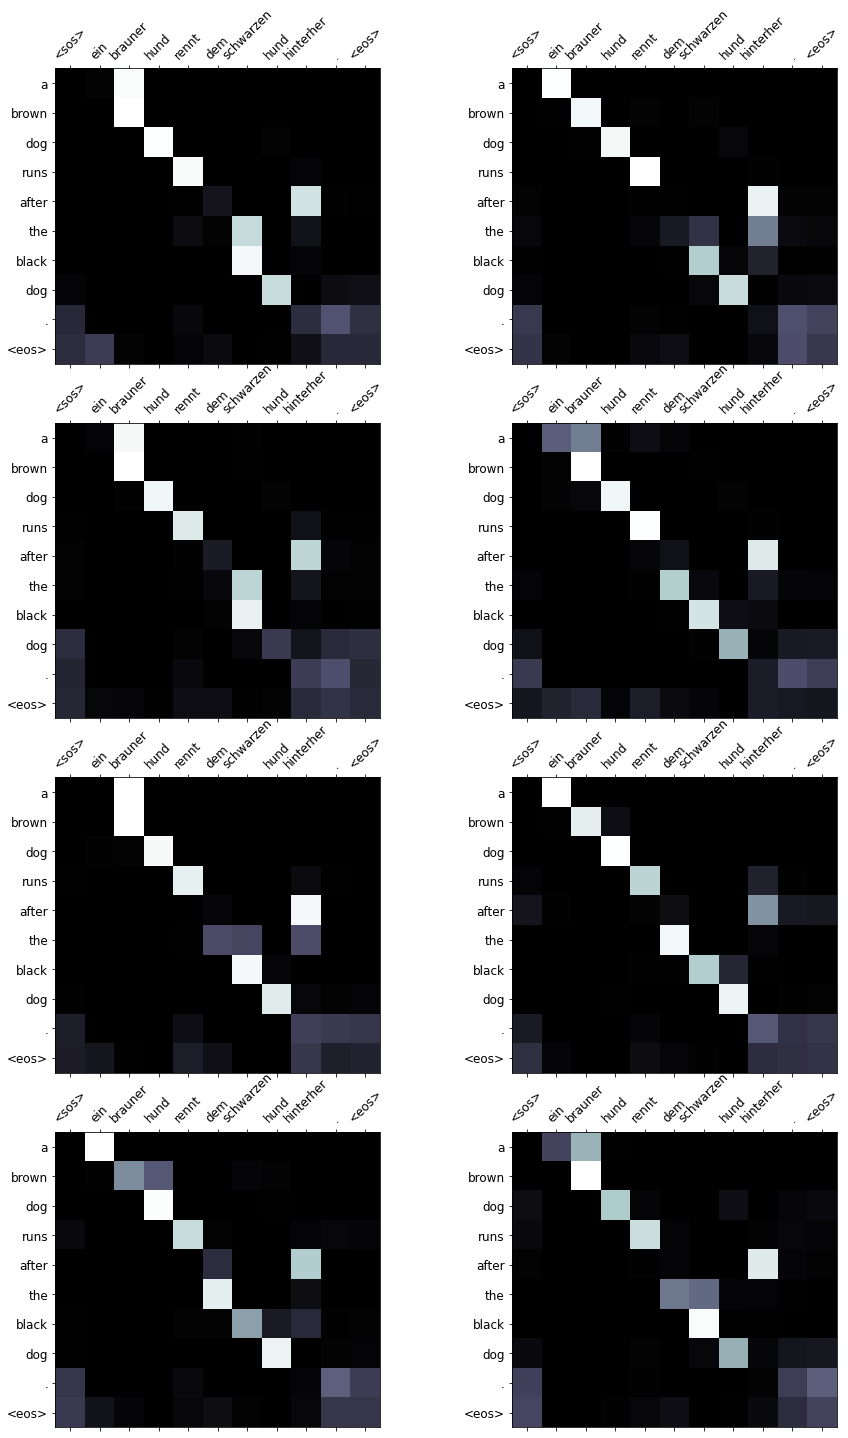

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [ ]:
translation, attention = sentence_translation(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'young', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


In [ ]:
display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []    
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        pred_trg, _ = sentence_translation(src, src_field, trg_field, model, device, max_len)
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.52


# Evaluation Results of the three models implemented

**All the three models were trained with ADAM as optimizer and experimented with different learning rates and it was noticed that Transformer took less time and achieved higher BLEU score. The details of the experiments and results are shown in the Figure below**


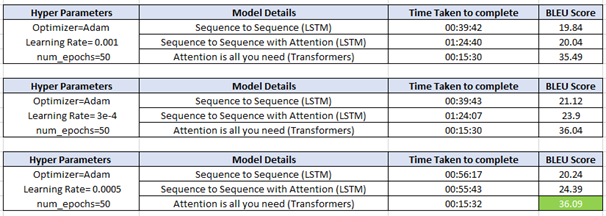

**All the three models were trained with ADAGRAD as optimizer and experimented with different learning rates and it was noticed that all the models including Transformer underperformed than when trained with ADAM. The details of the experiments and results are shown in the figure below.**


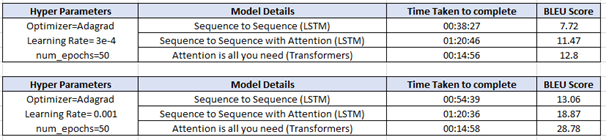
 
